# 6.3
## 6.3.1

In [4]:
import numpy as np
from IPython.core.pylabtools import figsize
import matplotlib.pyplot as plt
%matplotlib inline
import scipy.stats as stats

figsize(12.5, 3)
colors = ["#348ABD", "#A60628", "#7A68A6", "#467821"]

### Gamma Distribution

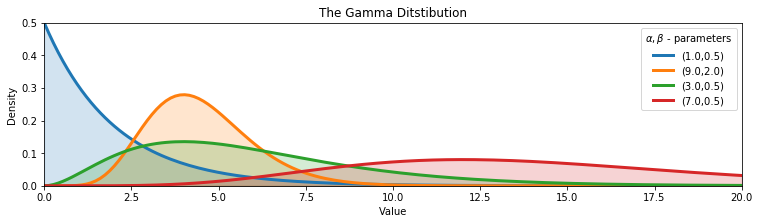

In [17]:
gamma = stats.gamma

parameters = [(1, 0.5), (9,2), (3, 0.5), (7, 0.5)]
x = np.linspace(0.001,20,150)
for alpha, beta in parameters:
    y = gamma.pdf(x, alpha, scale=1. / beta)
    lines = plt.plot(x,y,label="(%.1f,%.1f)" % (alpha, beta), lw = 3)
    plt.fill_between(x, 0, y, alpha=0.2, color=lines[0].get_color())
    plt.autoscale(tight=True)
    
plt.legend(title=r"$\alpha, \beta$ - parameters")
plt.xlabel('Value')
plt.ylabel('Density')
plt.title("The Gamma Ditstibution")


### Wishart Distribution

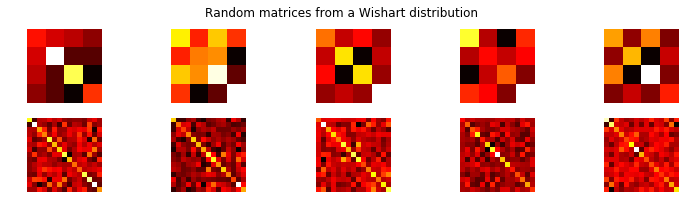

In [25]:
import pymc as pm

n = 4
hyperparameter = np.eye(n)
for i in range(5):
    ax = plt.subplot(2,5,i+1)
    plt.imshow(pm.rwishart(n + 1, hyperparameter),
              interpolation="none", cmap=plt.cm.hot)
    ax.axis("off")
    
n = 15
hyperparameter = 10 * np.eye(n)
for i in range(5, 10):
    ax = plt.subplot(2, 5, i+1)
    plt.imshow(pm.rwishart(n + 1, hyperparameter), interpolation="none", cmap=plt.cm.hot)
    ax. axis("off")
    
plt.suptitle("Random matrices from a Wishart distribution")
    

### Beta distribution

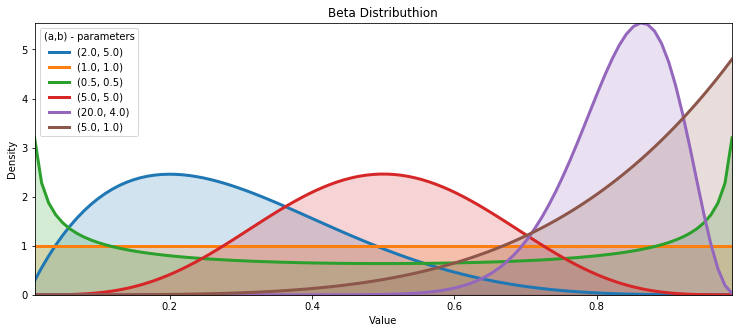

In [26]:
figsize(12.5,5)

params = [(2,5), (1,1), (0.5,0.5), (5,5), (20,4), (5,1)]
x = np.linspace(0.01, .99, 100)

beta = stats.beta
for a, b in params:
    y = beta.pdf(x, a, b)
    lines = plt.plot(x, y, label="(%.1f, %.1f)" % (a,b), lw = 3)
    plt.fill_between(x, 0, y, alpha=0.2, color=lines[0].get_color())
    plt.autoscale(tight=True)
    
plt.ylim(0)
plt.legend(loc='upper left',title = "(a,b) - parameters")
plt.xlabel("Value")
plt.ylabel('Density')
plt.title("Beta Distributhion")

# 6.4

In [35]:
from pymc import rbeta

class Bandits(object):
    """
    N個のバンディットを表すクラス。
    パラメータ：p_array:0から1までのN個の確率のnumpu array
    メソッド：pull(i):アームを引いた結果(0か1)を返す
    """
    
    def __init__(self, p_array):
        self.p = p_array
        self.optimal = np.argmax(p_array)
        
    def pull(self ,i):
        # i番目のアームを引く. 勝ったらTrue, 負けたらFalse
        return np.random.rand() < self.p[i] # 確率p[i]で勝つ=ランダムに出した確率変数が、p[i]より小さい
    
    def __len__(self):
        return len(self.p)
    
class BayesianStrategy(object):
    """
    多腕バンンディットもんだおを得オンライン学習の実装
    パラメータ:bantdits：bandisクラス
    メソッド:sample_bandits(n):n回引いて学習する
    属性：
    　N:サンプルの累積個数
      choices:N回の選択履歴のarray
      bb_score:N回のスコア履歴のarray
    """
    
    def __init__(self, bandits):
        self.bandits = bandits
        n_bandits = len(self.bandits)
        self.wins = np.zeros(n_bandits)
        self.trials = np.zeros(n_bandits)
        self.N = 0
        self.choices = []
        self.bb_score = []
        
    def sample_bandits(self, n=1):
        bb_score = np.zeros(n)
        choices = np.zeros(n)
        
        for k in range(n):
            #バンディットの事前分布からサンプリングし、
            #最も値の大きいサンプルを選択する
            choice = np.argmax(rbeta(1 + self.wins, 1 +  self.trials - self.wins))
            
            # 選択したバンディットからサンプル
            result = self.bandits.pull(choice)
            
            # 事前分布とスコア更新
            self.wins[choice] += result
            self.trials[choice] += 1
            bb_score[k] = result
            self.N += 1
            choices[k] = choice
            
        self.bb_score = np.r_[self.bb_score, bb_score]
        self.choices = np.r_[self.choices, choices]
    

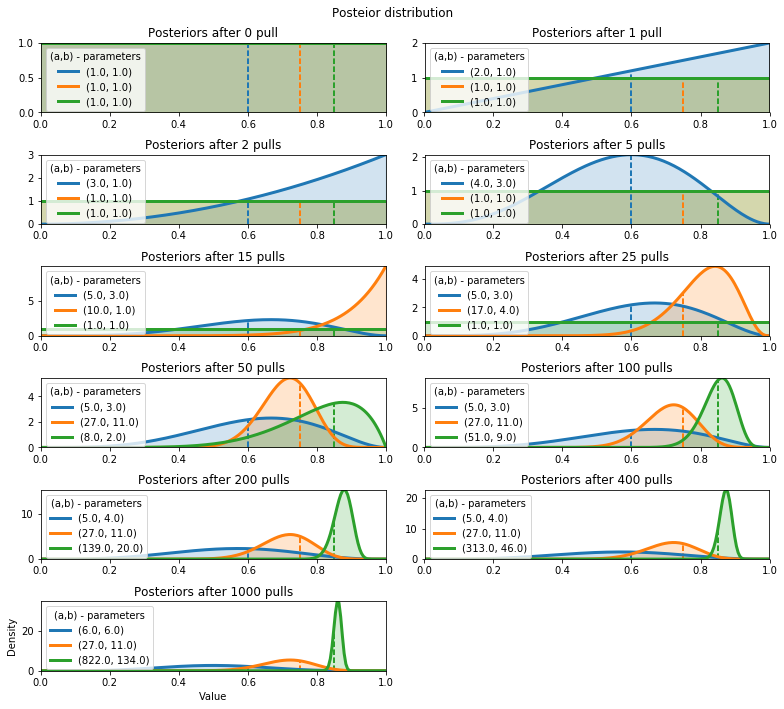

In [69]:
figsize(11.0, 10)

beta = stats.beta
x = np.linspace(0.001, .999, 200)

def plot_priors(bayesian_strategy, prob, lw=3, alpha=0.2, plt_vlines=True):
    # プロット関数
    wins = bayesian_strategy.wins
    trials = bayesian_strategy.trials
    
    for i in range(prob.shape[0]):
        a = 1 + wins[i]
        b = 1 + trials[i] - wins[i]
        y = beta(1 + wins[i], 1 + trials[i] - wins[i])
        p = plt.plot(x, y.pdf(x), lw=lw, label="(%.1f, %.1f)" % (a,b))
        c = p[0].get_markeredgecolor()
        plt.fill_between(x,y.pdf(x), 0,color=c, alpha=alpha)
#                        label="underlying probability: %.2f" % prob[i]) # 未知の確率
        if plt_vlines:
            plt.vlines(prob[i], 0, y.pdf(prob[i]),colors=c, linestyles="--", lw=2)
            
        plt.autoscale(tight = "False")
        plt.legend(loc='upper left',title = "(a,b) - parameters")
        plt.title("Posteriors after %d pull" % bayesian_strategy.N + \
                 "s" * (bayesian_strategy.N > 1),)
        
    return

hidden_prob = np.array([0.60, 0.75, 0.85])
bandits = Bandits(hidden_prob)
bayesian_start = BayesianStrategy(bandits)

draw_samples = [0,1, 1, 3, 10, 10, 25, 50, 100, 200, 600]

for j, i in enumerate(draw_samples):
    plt.subplot(6,2, j+1)
    bayesian_start.sample_bandits(i)
    plot_priors(bayesian_start, hidden_prob)
    plt.autoscale(tight=True)
    
plt.xlabel('Value')
plt.ylabel('Density')
plt.tight_layout()

plt.suptitle("Posteior distribution")
plt.subplots_adjust(top=.93)
        

#### Check changing beta with wins and trials

In [81]:
wins = np.array([3,2,1]) #= bayesian_start.wins
trials = np.array([7,2,1])# bayesian_start.trials
print(wins)
print(trials)
y = beta(1 + wins[0], 1 + trials[0] - wins[0])
print(y.ppf(x))

[3 2 1]
[7 2 1]
[ 0.06482953  0.10505848  0.12431648  0.13820401  0.14940502  0.15895049
  0.16735782  0.17492738  0.18185068  0.18825807  0.19424272  0.19987374
  0.20520399  0.21027489  0.21511955  0.21976491  0.22423324  0.22854312
  0.23271031  0.23674823  0.24066849  0.24448112  0.24819494  0.2518177
  0.25535624  0.25881668  0.26220449  0.26552457  0.26878135  0.27197886
  0.27512074  0.27821033  0.28125068  0.28424458  0.28719462  0.29010317
  0.29297244  0.29580447  0.29860116  0.30136427  0.30409547  0.30679629
  0.30946818  0.3121125   0.31473053  0.31732348  0.31989249  0.32243861
  0.32496288  0.32746626  0.32994965  0.33241394  0.33485994  0.33728844
  0.3397002   0.34209593  0.34447632  0.34684204  0.3491937   0.35153191
  0.35385727  0.35617031  0.3584716   0.36076164  0.36304093  0.36530996
  0.36756921  0.36981911  0.37206012  0.37429265  0.37651713  0.37873395
  0.38094351  0.38314619  0.38534236  0.38753238  0.38971662  0.39189541
  0.3940691   0.39623802  0.3984025 

#### check rbeta

0.181914026045 0.999745630351
[ 0.18191403  0.19017495  0.19843588  0.2066968   0.21495773  0.22321865
  0.23147958  0.2397405   0.24800143  0.25626235  0.26452328  0.2727842
  0.28104513  0.28930605  0.29756698  0.30582791  0.31408883  0.32234976
  0.33061068  0.33887161  0.34713253  0.35539346  0.36365438  0.37191531
  0.38017623  0.38843716  0.39669808  0.40495901  0.41321993  0.42148086
  0.42974178  0.43800271  0.44626364  0.45452456  0.46278549  0.47104641
  0.47930734  0.48756826  0.49582919  0.50409011  0.51235104  0.52061196
  0.52887289  0.53713381  0.54539474  0.55365566  0.56191659  0.57017751
  0.57843844  0.58669937  0.59496029  0.60322122  0.61148214  0.61974307
  0.62800399  0.63626492  0.64452584  0.65278677  0.66104769  0.66930862
  0.67756954  0.68583047  0.69409139  0.70235232  0.71061324  0.71887417
  0.7271351   0.73539602  0.74365695  0.75191787  0.7601788   0.76843972
  0.77670065  0.78496157  0.7932225   0.80148342  0.80974435  0.81800527
  0.8262662   0.834527

TypeError: unorderable types: beta_gen() > int()

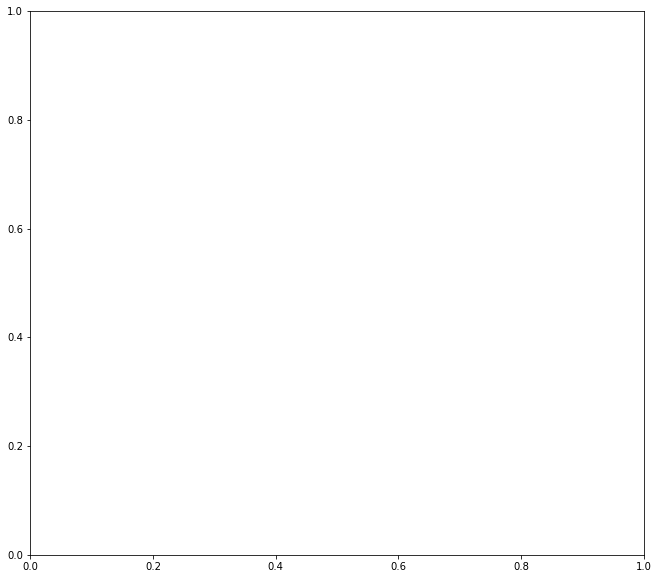

In [87]:
fig, ax = plt.subplots(1, 1)
a, b = 2.31, 0.627
mean, var, skew, kurt = beta.stats(a, b, moments='mvsk')
print(beta.ppf(0.01,a,b),beta.ppf(0.99,a,b))
x = np.linspace(beta.ppf(0.01, a, b), beta.ppf(0.99, a, b), 100)
print(x)
beta.ppf(np.random.random(3), alpha, beta)
ax.plot(x, beta.pdf(x, a, b),'r-', lw=5, alpha=0.6, label='beta pdf')

## 6.4.3

In [88]:
from urllib.request import urlretrieve
# other_start.pyのダウンロード
urlretrieve("https://git.io/vXL9A", "other_starts.py")

('other_starts.py', <http.client.HTTPMessage at 0x116bca470>)

In [89]:
figsize(12.5,5)
from other_starts import *

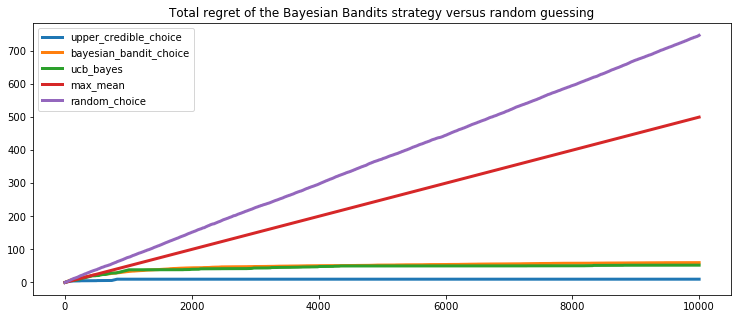

In [97]:
# もっと難しい問題を定義
hidden_prob = np.array([0.15,0.2,0.1,0.05])
bandits = Bandits(hidden_prob)

# define regret
def regret(probabilities, choices):
    w_opt = probabilities.max()
    return (w_opt - probabilities[choices.astype(int)]).cumsum()

# make new strategy
strategies = [upper_credible_choice, bayesian_bandit_choice, ucb_bayes, max_mean, random_choice]
algos = []
for strat in strategies:
    algos.append(GeneralBanditStrat(bandits, strat))
    
for strat in algos:
    strat.sample_bandits(10000)

    
for i, strat in enumerate(algos):
    _regret = regret(hidden_prob, strat.choices)
    plt.plot(_regret, label=strategies[i].__name__, lw=3)
    
plt.title("Total regret of the Bayesian Bandits strategy versus random guessing")
plt.legend(loc="upper left")